In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import functools
import pickle
from operator import add
import uncertainty_toolbox as uct
import matplotlib as mpl
from alpdesign.utils import *
from alpdesign.mlp import *
#from jax_unirep import get_reps
import alpdesign
import os
from shapely.geometry import Polygon, LineString
from shapely.ops import polygonize, unary_union

%matplotlib inline

In [2]:
AA_list = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V','B','Z','X','*']
blosum92 = np.loadtxt("./blosum62.txt", dtype='i', delimiter=' ')

avg92 = jnp.sum(blosum92)/24/24
sum92 = 0.
for row in blosum92:
    for aa in row:
        sum92 += (aa-avg92)**2
std92 = jnp.sqrt(sum92 / 24/24)

def blosum(seq1, seq2):
    seqlist1 = list(seq1)
    seqlist2 = list(seq2)
    score = 0.
    for i in range(len(seqlist1)):
        idx1 = AA_list.index(seqlist1[i])
        idx2 = AA_list.index(seqlist2[i])
        score += (blosum92[idx1][idx2] - avg92)/std92
        #jax.nn.sigmoid(score/len(seqlist1))
    return score/len(seqlist1)

In [3]:
target_seq = 'TARGETPEPTIDE'
key = jax.random.PRNGKey(0)
c = alpdesign.EnsembleBlockConfig()
forward_t, full_forward_t, seq_t , uncertainty_eval_t = alpdesign.build_e2e(c)
#def gen(k, n): return jax.random.normal(k, shape=(n, 13, 20))
train_t = full_forward_t
aconfig = AlgConfig()
c = alpdesign.EnsembleBlockConfig()

with open('../10kseqs.txt') as f:
    readfile = f.readlines()
    random_seqs = f'{readfile[0]}'.split(' ')[:-1]
    

def get_labels(seqs):
    labels = []
    for seq in seqs:
        labels.append(blosum(target_seq, seq))
    labels = np.array(labels)

    return labels



    
'''    

#print(get_reps(['AAA','RRR'])[0])

def get_labels(seqs):
    labels = []
    for seq in seqs:
        rep = get_reps(seq)[0]
        labels.append(rep[0][-1])
    labels = np.array(labels)
    return labels
'''

"    \n\n#print(get_reps(['AAA','RRR'])[0])\n\ndef get_labels(seqs):\n    labels = []\n    for seq in seqs:\n        rep = get_reps(seq)[0]\n        labels.append(rep[0][-1])\n    labels = np.array(labels)\n    return labels\n"

In [10]:
def get_aanum(seqs):
    aa_count = []
    for seq in seqs:
        seq_list = list(seq)
        aa_num = [float(seq_list.count(aa)) for aa in AA_list]
        aa_count.append(aa_num)
    aa_count = jnp.array(aa_count)
    return aa_count

a = get_aanum(train_seqs)

In [12]:
print(a.shape)

(20, 24)


In [5]:
batch_size = 8
def get_results(key, params, rep_list):
    means = []
    stds = []
    # need batch
    for i in range(0, len(rep_list)//batch_size):
    #for rep in rep_list:
        batch_reps = rep_list[i * batch_size: (i + 1) * batch_size]
        #yhat = forward_t.apply(params, key, batch_reps)
        print(yhat.shape)
        means.append(yhat[0])
        stds.append(yhat[1])
    return np.array(means), np.array(stds)

def get_single_results(key, params, rep_list):
    yhats = []
    # need batch
    for rep in rep_list:
        yhat = naive_forward_t.apply(params, key, rep)
        yhats.append(yhat[1])
    return np.array(yhats)

In [13]:
validation_seqs = [random.choice(random_seqs) for i in range(50)]
validation_reps = get_aanum(validation_seqs)
validation_labels = get_labels(validation_seqs)
test_seqs = [random.choice(random_seqs) for i in range(160)]
test_reps = get_aanum(test_seqs)
test_labels = get_labels(test_seqs)

#print(validation_reps.shape)

In [14]:
train_seqs = [random.choice(random_seqs) for i in range(20)]
train_reps = get_aanum(train_seqs)
train_labels = get_labels(train_seqs)

In [14]:
batch_seqs = jnp.ones([aconfig.train_batch_size, 1900])
params = train_t.init(key, jnp.tile(
            batch_seqs, (5, 1, 1)))
ensemble_seqs = jnp.tile(batch_seqs, (5, 1, 1))
a = train_t.apply(params, key, ensemble_seqs)
a0 = a[...,0]
a1 = a[...,1]
n_log_likelihoods = 0.5 * jnp.log(a1)
loss = jnp.sum(n_log_likelihoods)
print(loss)

nan


In [15]:
params, train_loss, val_loss = ensemble_train(
        key, train_t, c, train_reps, train_labels, val_seqs=validation_reps, val_labels=validation_labels, aconfig=aconfig
    )

training in progress


In [11]:
params, train_loss, val_losses = naive_train(
        key, naive_forward_t, train_reps, train_labels, val_seqs=validation_reps, val_labels=validation_labels, params=None
    )

2021-11-21 23:38:06.690617: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2085] Execution of replica 0 failed: Internal: Failed to load in-memory CUBIN: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered


RuntimeError: Internal: Failed to load in-memory CUBIN: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered

Text(0.5, 0, 'epochs')

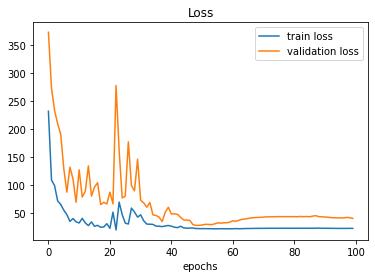

In [8]:
plt.figure()
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.title('Loss')
plt.legend()
plt.xlabel('epochs')



In [9]:

y_pred, y_std = get_results(key, params, test_reps)
#(exp_proportions, obs_proportions) = uct.get_proportion_lists(y_pred, y_std, validation_labels)



AttributeError: 'tuple' object has no attribute 'shape'

In [31]:
y_pred = get_single_results(key, params, test_reps)

In [32]:
def parity_plot(y_pred, test_labels):
    ground_truth = test_labels
    pred = y_pred

    plt.scatter(ground_truth, pred, c='lightskyblue', alpha=0.3)
    plt.plot( [-0.5,1.0],[-0.5,1.0], color='lightsalmon', linewidth=2)
    plt.title('Parity Plot')
    plt.xlim([-0.5, 1.0])
    plt.ylim([-0.5, 1.0])
    plt.xlabel('Ground truth')
    plt.ylabel('Predictions')
    plt.grid()
    return plt


def calibration_plot(y_pred, y_std, test_labels):
    (exp_proportions, obs_proportions) = uct.get_proportion_lists_vectorized(y_pred, y_std, test_labels)
    plt.figure()
    ax = plt.gca()
    ax.plot(exp_proportions, obs_proportions, c="#1f77b4")
    #ax.set_title('Calibration Parity Plot %d' % num)
    ax.set_title('Calibration Plot')
    ax.set_xlabel("Predicted Proportion in Interval")
    ax.set_ylabel("Observed Proportion in Interval")
    ax.axis("square")
    ax.grid()
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.plot(exp_proportions, exp_proportions, '--', c='orange')
    ax.fill_between(exp_proportions, exp_proportions, obs_proportions, alpha=0.2)
    polygon_points = []
    for point in zip(exp_proportions, obs_proportions):
        polygon_points.append(point)
    for point in zip(reversed(exp_proportions), reversed(exp_proportions)):
        polygon_points.append(point)
    polygon_points.append((exp_proportions[0], obs_proportions[0]))
    polygon = Polygon(polygon_points)
    x, y = polygon.exterior.xy  # original data
    ls = LineString(np.c_[x, y])  # closed, non-simple
    lr = LineString(ls.coords[:] + ls.coords[0:1])
    mls = unary_union(lr)
    polygon_area_list = [poly.area for poly in polygonize(mls)]
    miscalibration_area = np.asarray(polygon_area_list).sum()
    ax.text(
            x=0.95,
            y=0.05,
            s="Miscalibration area = %.2f" % miscalibration_area,
            verticalalignment="bottom",
            horizontalalignment="right",
            fontsize="small",
        )

<module 'matplotlib.pyplot' from '/home/zyang43/.conda/envs/prettyB/lib/python3.9/site-packages/matplotlib/pyplot.py'>

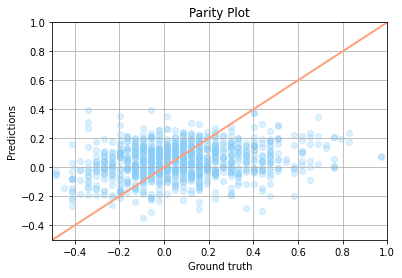

In [33]:
parity_plot(y_pred, validation_labels)